## 1. The Problem

<p style="font-family:'Courier New'"> <font size = 3>We have a new job: Create an Spam Filter, in other words, a system that detects if an email is an spam, and remove them, so lets think

<p style="font-family:'Courier New'"> <font size = 3>This problem will be resolved using classification, so we will work with the recall/precision concepts, but imagine, whats is the best? a system that removes an important email classifying then as spam, or a system that miss some spam? of course a system that will miss some spam emails, so our scoring will be based in the 'precision' concept
<br><br>
    
<center>$Precision = \frac{TP}{TP+FP}$</center>
<br>
    
<p style="font-family:'Courier New'"> <font size = 3>Okay, and what we do about the text?

<p style="font-family:'Courier New'"> <font size = 3>In the text, you can apply some filter, like, replace url's with the tag 'url', replace number's with 'number' text, remove ponctuation and some unecessary space, and then, apply the tfidf concept to generate an vector representing the text


In [223]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

## 2. Reading the data

In [171]:
df = pd.read_csv('Data/emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


<p style="font-family:'Courier New'"> <font size = 3>Look, our data is simple, we have the text of the email and the label, meaning spam or not, before start the modeling, we will do some preprocessing and exploratory data analysis to know our data


## 3. Data Preprocessing

<p style="font-family:'Courier New'"> <font size = 3>To make an standard processing, we can work with the pipeline concept

In [301]:
class TextClean(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self,x ,y=None):
        x['text'] = x['text'].apply(lambda x: re.sub('[0-9]+','Number',x))
        x['text'] = x['text'].apply(lambda x: re.sub('http : / /[\w\W]+. com /', 'URL', x))
        x['text'] = x['text'].apply(lambda x: re.sub(r'[.,;$%&*@!#-=?"]', '', x))
        x['text'] = x['text'].apply(lambda x: re.sub(r'Subject', '', x))
        x['text'] = x['text'].apply(lambda x: x.lower())
        
        return x

class TextVectorization(BaseEstimator, TransformerMixin):
    
    def __init__(self, vect):
        self.vectorizer = vect
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y= None):
        self.vectorizer.fit(df['text'])
        X = self.vectorizer.transform(x['text'])
        return X

In [302]:
vectorizer = TfidfVectorizer(stop_words='english')


pipeline = Pipeline([('TextClean',TextClean()),
                     ('TextVectorization', TextVectorization(vectorizer))])

In [303]:
X = pipeline.fit_transform(df)

In [304]:
x_train, x_test, y_train, y_test = train_test_split(X, df['spam'], test_size= 0.2)

## 4. Exploratory Data Analysis

<BarContainer object of 2 artists>

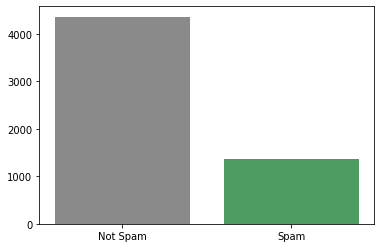

In [158]:
plt.bar(x = ['Not Spam', 'Spam'], height= [ len(df[df['spam']==0]), len(df[df['spam']==1]) ], color = ['#8a8a8a','#4c9c5f'])

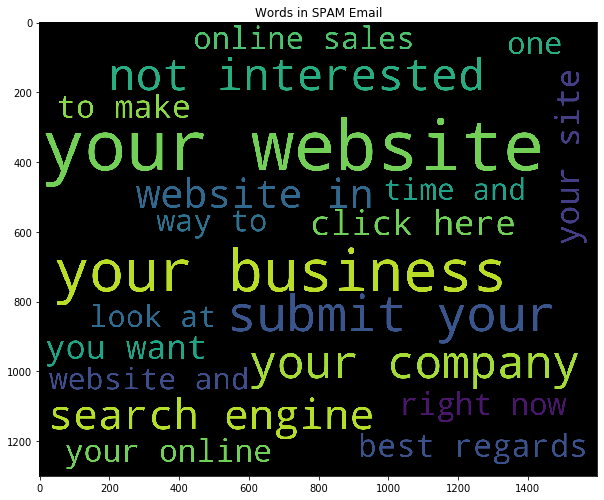

In [159]:
words_spam = ''
for msg in df[df['spam']==1]['text']:
    msg = msg.lower()
    if('number' in msg):
        pass
    else:
        words_spam += ' ' + msg
w = WordCloud(width=1600,height=1300,mode='RGBA',background_color='black',max_words=20).generate(words_spam)
plt.figure(figsize=(10,10))
plt.title('Words in SPAM Email')
plt.imshow(w)

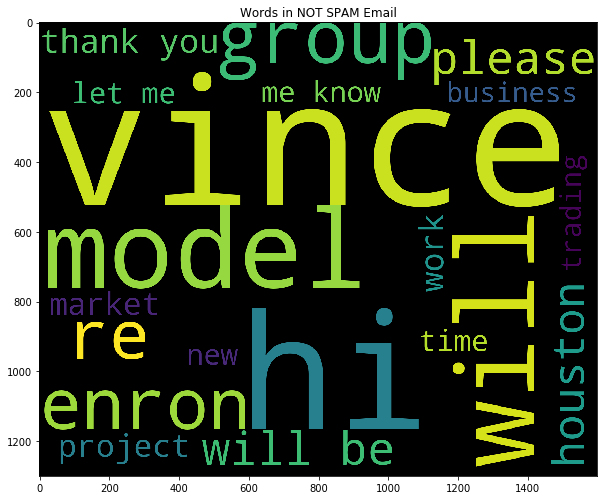

In [160]:
words_not_spam = ''
for msg in df[df['spam']==0]['text']:
    msg = msg.lower()
    if('number' in msg):
        pass
    else:
        words_not_spam += ' ' + msg
w = WordCloud(width=1600,height=1300,mode='RGBA',background_color='black',max_words=20).generate(words_not_spam)
plt.figure(figsize=(10,10))
plt.title('Words in NOT SPAM Email')
plt.imshow(w)

<p style="font-family:'Courier New'"> <font size = 3>Look, we can se an pattern, in the spam emails, some words are found like free, to receive and click here, probably refering to an email offering some product, so a spam, in other hand, the normal email has words like thank you, let me know, business

## 5. Classification Model

### 5.1. MultinomialNB

In [99]:
MultiNB = MultinomialNB()

MultiNB.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [109]:
y_pred = MultiNB.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[840,   1],
       [129, 176]], dtype=int64)

<p style="font-family:'Courier New'"> <font size = 3>We have 840 True Negatives, 1 False positive, 129 False Negative and 176 True positive

<p style="font-family:'Courier New'"> <font size = 3>In other words:

<p style="font-family:'Courier New'"> <font size = 3>840 non spam emails was classified as non spam;

<p style="font-family:'Courier New'"> <font size = 3>1 was classified as spam but its not

<p style="font-family:'Courier New'"> <font size = 3>129 spams was classified as not spam

<p style="font-family:'Courier New'"> <font size = 3>176 spam email was classified correctly

### 5.2. SVC

In [257]:
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[881,   2],
       [  7, 256]], dtype=int64)

<p style="font-family:'Courier New'"> <font size = 3>Look how we got better results

<p style="font-family:'Courier New'"> <font size = 3>we have 0 normal emails classified as spam, and now we have 13 (93% less) spam emails classified as normal email

<p style="font-family:'Courier New'"> <font size = 3>Lets do some fine tuning with gridsearch

In [224]:
svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'degree':[2,3,4]}
clf = GridSearchCV(svc, parameters, return_train_score=True, scoring='precision', cv = 5)


In [225]:
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'degree': [2, 3, 4],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='precision', verbose=0)

In [256]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[883,   0],
       [  4, 259]], dtype=int64)

<p style="font-family:'Courier New'"> <font size = 3> The fine tuning produced some better results, as we wanted 0 for false positive and reduced the number of False Negative</p>

### 5.3. Random Forest

In [200]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=20000, max_features = 'auto',verbose = 1, bootstrap = True)



rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
confusion_matrix(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   53.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


array([[856,   2],
       [ 29, 259]], dtype=int64)

## 5.4. XGBoost

In [218]:
xgb_model = xgb.XGBClassifier()

param = {'max_depth': [2,3,4,5,6,7,25,40,1000], 
         'learning_rate': [0.01,0.05,0.1,0.5,1], 
         'verbosity': [2], 
         'objective': ['multi:softmax'], 
         'num_class': [3], 
         'eval_metric': ['merror','aucpr','auc']}

clf = GridSearchCV(xgb_model, param, n_jobs=-1, cv=5, scoring='precision', verbose=2, refit=True)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 150.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 345.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 586.7min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 610.4min finished


[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:49:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned n

[18:49:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[18:49:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:49:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:49:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:49:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:49:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned n

[18:49:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:49:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:49:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:49:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[18:49:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[18:49:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned n

[18:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned n

[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:50:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned n

[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:50:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned n

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'eval_metric': ['merror', '

In [222]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[845,  13],
       [  6, 282]], dtype=int64)

## 6. Classifying emails i received

<p style="font-family:'Courier New'"> <font size = 3>I choose 4 emails, email1 (Not Spam), email2 and email3 (Spam) and email4(Not spam)

In [275]:
email1 = ("Estuda.com ENEM Hello, You haven't studied at Estuda.com ENEM for 28 days, don't miss a beat." 
"Continue your preparation with The biggest questions site for ENEM and Vestibular in Brazil."
"Prepare yourself by answering tests or study through simulations"
"Go back to Estuda.com ENEM and continue studying."
'Access now https: //app.estuda.com/'

"P.S .: Did you miss something on our platform, help us by participating in our quick survey")
email2 = ("EASY CREDIT WITH THE BEST"
'MARKET FEES'
'The personal loan has numerous advantages. In addition to having quick release,' 
'compared to overdraft, the rates are much more attractive. Whoever has a compromised'
'name can also withdraw the money. Doing a simulation now, we put you in touch with one of our loan partners.'
'I want money now'
'WITHOUT BUROCRACY I want money now'
'LOWER RATES I want money now'
'100% ONLINE'
'SIMULATE')

email3 = ('Header-30Days-2'
'Hello, how are you?'

'We are living in difficult times and the best thing to do at'
'that moment is to take care of your health and prepare yourself at home for when all this is over.'

'Our platform has more than 1250 online courses * with a certificate recognized and valid throughout Brazil *.'

'Want to know * what courses we have? * See here: PreparaTOS ALL Courses'

"And believe me, * it's not a prank *."

'After 30 days, cancellation is free and automatic.'

'You only pay the monthly fee if you like it and want to continue using it.'


'Would you like to start your * 30 days FREE OF CHARGE * now?')

email4 = ('Medium Logo Stories for Today’s highlights This Is How Much YouTube Paid Me for My 1,000,000 Viewed Video'
'Here is the answer to the question that everyone asks me'
'Shelby Church in OneZeroMember only content5 min read'
'Coronavirus Made a Big Mistake Invading the Greatest Goddamn Country on Earth'
'If the ’rona didn’t want a roundhouse kick to the face, it should have stayed the eff out of ‘Merica'
'Drew Magary in GENMember only content5 min read'
'How to Get a Job with Python'
'It is a simple use of Python, you do not need any specific skills to do this with me. We will go step by step…'
'Lazar Gugleta in Towards Data ScienceMember only content7 min read'
'The End of the Pandemic Is Nearly Here'
'So what does the end of the pandemic look like?'
'Tim Denning in Mind CafeMember only content4 min read'
'Quick reads'
'Mid-30s Vs. Mid-20s Millennial Men'
'It takes a while, but change eventually happens.'
'Andrew Hutchinson in SlackjawMember only content2 min read'
'TypeScript Antipatterns to Avoid'
'We should avoid anti-patterns by using TypeScript’s type inference capabilities.'
'John Au-Yeung in Level Up CodingMember only content4 min read'
'The Virus vs The Virus:'
'A Trump Twitter Timeline'
'Dave PellMember only content2 min read'
'Most read'
'Being a Telemarketer Saved My Life'
'Cold-calling 800 people a day gives you a rare window into human nature'
'Alex C. Bonesteel in Human PartsMember only content13 min read'
)

test2 = pd.DataFrame([email1,email2,email3,email4], columns=["text"])

In [308]:
test2 = pd.concat([df,test2])
test2 = test2.reset_index(drop=True)
x_test2 = pipeline.transform(pd.DataFrame([email1,email2,email3,email4], columns=["text"]))

In [309]:
svc = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(x_train, y_train)
svc.predict(x_test2)

array([0, 1, 1, 0], dtype=int64)

Look, its how we proposed!!!!!


But, lets build some application to someone test if the emails si a ham or a spam